In [3]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import re
import time
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
%matplotlib inline 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense


In [4]:
dataset = '../data/spam - spam.csv'

In [5]:
df = pd.read_csv(dataset)
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# relace v1 with target and v2 with message
df = df.rename(columns={'v1': 'target', 'v2': 'message'})
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.head()


,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
print(f'Number of duplicated rows are', df.duplicated().sum())
print(f'The shape of the dataset is', df.shape)
df[df.duplicated()]


Number of duplicated rows are 409
The shape of the dataset is (5572, 2)


,target,message
102,ham,As per your request 'Melle Melle (Oru Minnamin...
153,ham,As per your request 'Melle Melle (Oru Minnamin...
206,ham,"As I entered my cabin my PA said, '' Happy B'd..."
222,ham,"Sorry, I'll call later"
325,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [8]:
df.drop_duplicates(inplace=True)
print(f'The shape of the dataset after removing duplicate is ', df.shape)

The shape of the dataset after removing duplicate is  (5163, 2)


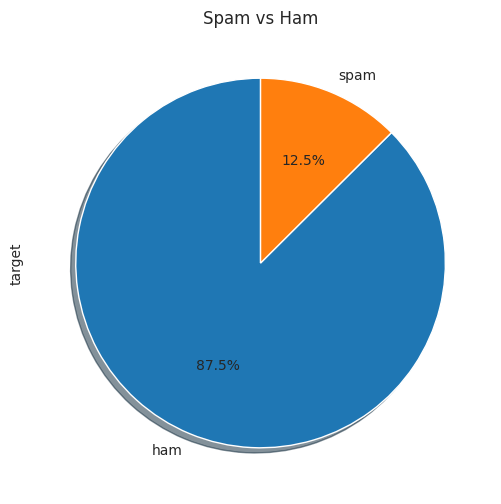

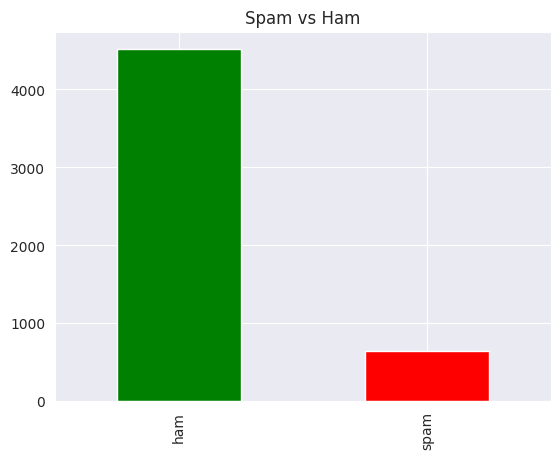

In [9]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
df['target'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Spam vs Ham')
plt.show()

df['target'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Spam vs Ham')
plt.show()

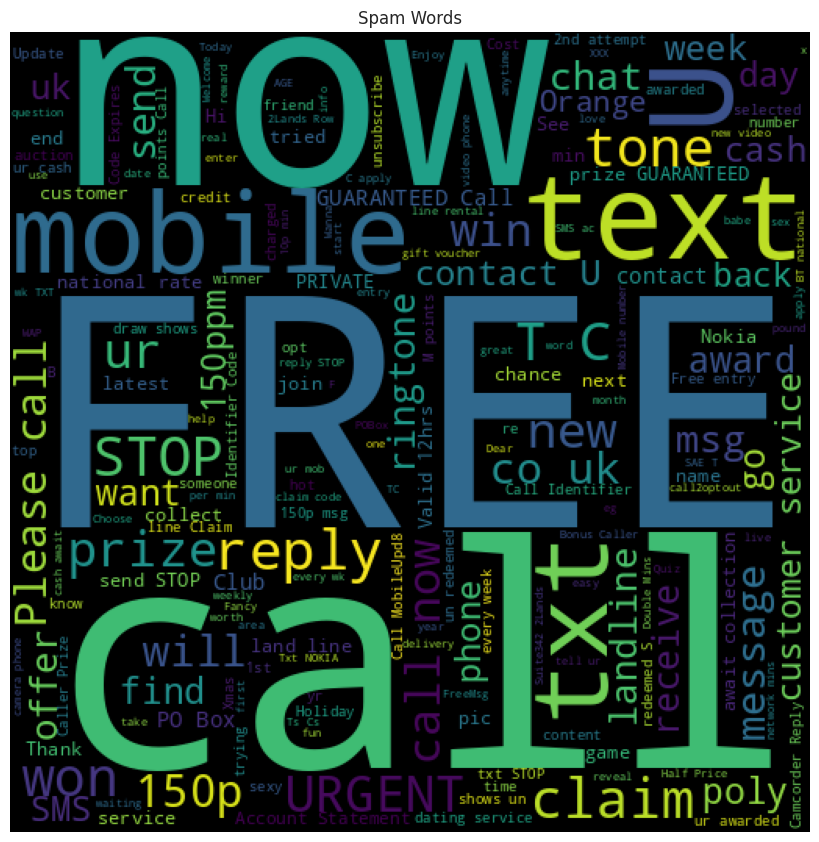

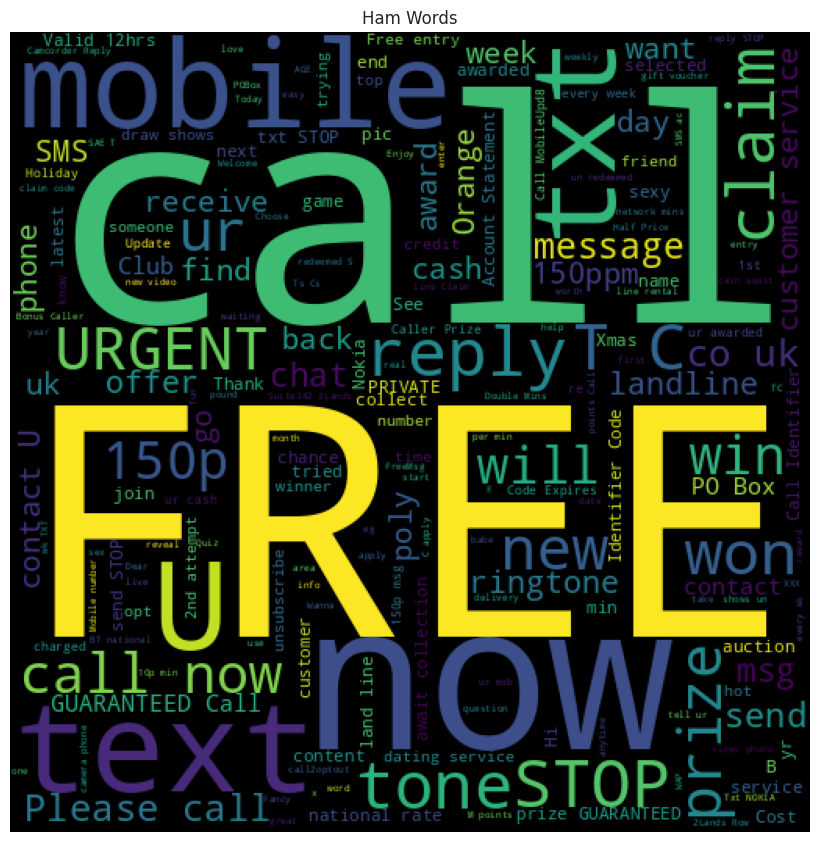

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

spam_words = ' '.join(list(df[df['target'] == 'spam']['message']))
spam_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Spam Words')
plt.show()

ham_words = ' '.join(list(df[df['target'] == 'ham']['message']))
ham_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize=(10, 8), facecolor='w')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Ham Words')
plt.show()


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])
df.head()

,target,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df['lines'] = df['message'].apply(lambda x: len(nltk.sent_tokenize(x)))
df['words'] = df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
df['characters'] = df['message'].apply(lambda x: len(x))
df.head()

,target,message,lines,words,characters
0,0,"Go until jurong point, crazy.. Available only ...",2,24,111
1,0,Ok lar... Joking wif u oni...,2,8,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,2,37,155
3,0,U dun say so early hor... U c already then say...,1,13,49
4,0,"Nah I don't think he goes to usf, he lives aro...",1,15,61


In [13]:
df.describe()

,target,lines,words,characters
count,5163.000000,5163.000000,5163.000000,5163.000000
mean,0.125315,1.963974,18.444122,78.811156
std,0.331108,1.448008,13.327940,58.153491
min,0.000000,1.000000,1.000000,2.000000
25%,0.000000,1.000000,9.000000,36.000000
50%,0.000000,1.000000,15.000000,60.000000
75%,0.000000,2.000000,26.000000,116.000000
max,1.000000,38.000000,220.000000,910.000000


In [14]:
print(f'Description of the Spam messages')
df[df['target'] == 1].describe()

Description of the Spam messages


,target,lines,words,characters
count,647.0,647.000000,647.000000,647.000000
mean,1.0,2.967543,27.659969,137.318393
std,0.0,1.490069,7.038065,30.096861
min,1.0,1.000000,2.000000,13.000000
25%,1.0,2.000000,25.000000,130.000000
50%,1.0,3.000000,29.000000,148.000000
75%,1.0,4.000000,32.000000,157.000000
max,1.0,9.000000,46.000000,223.000000


In [15]:
print(f'Description of the Ham messages')
df[df['target'] == 0].describe()

Description of the Ham messages


,target,lines,words,characters
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,1.820195,17.123782,70.428919
std,0.0,1.383657,13.493970,56.356310
min,0.0,1.000000,1.000000,2.000000
25%,0.0,1.000000,8.000000,34.000000
50%,0.0,1.000000,13.000000,52.000000
75%,0.0,2.000000,22.000000,90.000000
max,0.0,38.000000,220.000000,910.000000


In [16]:
def cleanText(text):
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [re.sub(r'[^a-zA-Z0-9]', '', word) for word in text]
    text = [word for word in text if word not in stopwords.words('english')]
    text = list(filter(None, text))
    text = ' '.join(text)
    token = nltk.word_tokenize(text)
    stem = [ps.stem(word) for word in token]
    lamm = [lemmatizer.lemmatize(word) for word in token]
    return text, stem, lamm

df['cleaned_text'] = df['message'].apply(lambda x: cleanText(x)[0])
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: str(x).replace('[', '').replace(']', ''))
df['stemed_text'] = df['message'].apply(lambda x: cleanText(x)[1])
df['stemed_text'] = df['stemed_text'].apply(lambda x: str(x).replace('[', '').replace(']', ''))
df['lemmatized_text'] = df['message'].apply(lambda x: cleanText(x)[2])
df['lemmatized_text'] = df['lemmatized_text'].apply(lambda x: str(x).replace('[', '').replace(']', ''))


In [17]:
df.head()

,target,message,lines,words,characters,cleaned_text,stemed_text,lemmatized_text
0,0,"Go until jurong point, crazy.. Available only ...",2,24,111,go jurong point crazy available bugis n great ...,"'go', 'jurong', 'point', 'crazi', 'avail', 'bu...","'go', 'jurong', 'point', 'crazy', 'available',..."
1,0,Ok lar... Joking wif u oni...,2,8,29,ok lar joking wif u oni,"'ok', 'lar', 'joke', 'wif', 'u', 'oni'","'ok', 'lar', 'joking', 'wif', 'u', 'oni'"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,2,37,155,free entry 2 wkly comp win fa cup final tkts 2...,"'free', 'entri', '2', 'wkli', 'comp', 'win', '...","'free', 'entry', '2', 'wkly', 'comp', 'win', '..."
3,0,U dun say so early hor... U c already then say...,1,13,49,u dun say early hor u c already say,"'u', 'dun', 'say', 'earli', 'hor', 'u', 'c', '...","'u', 'dun', 'say', 'early', 'hor', 'u', 'c', '..."
4,0,"Nah I don't think he goes to usf, he lives aro...",1,15,61,nah nt think goes usf lives around though,"'nah', 'nt', 'think', 'goe', 'usf', 'live', 'a...","'nah', 'nt', 'think', 'go', 'usf', 'life', 'ar..."


In [18]:
df_models = pd.DataFrame(columns=['model_name', 'accuracy', 'time_taken'])

In [19]:
cv = CountVectorizer()  

X_train, X_test, y_train, y_test = train_test_split(df['message'], df['target'], test_size=0.2, random_state=42)

In [20]:
# fit the model
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

trainGaus=X_train_cv.toarray()
testGaus=X_test_cv.toarray()

# train the model
models = [MultinomialNB(), BernoulliNB()]
for model in models:
    model = model.fit(X_train_cv, y_train)
    y_pred = model.predict(X_test_cv)
    y_pred
    print(f'Accuracy of the {model} model is', accuracy_score(y_test, y_pred)*100)    

model = GaussianNB()
start = time.time()
model.fit(X_train_cv.toarray(), y_train)
y_pred = model.predict(X_test_cv.toarray())
y_pred
print(f'Accuracy of the {model} model is', accuracy_score(y_test, y_pred)*100)
# Accuracy of the MultinomialNB() model with text cleaning is 97.2894482090997
# Accuracy of the BernoulliNB() model with text cleaning is 96.51500484027106
# Accuracy of the GaussianNB() model with text cleaning is 88.2865440464666

Accuracy of the MultinomialNB() model is 98.16069699903196
Accuracy of the BernoulliNB() model is 97.38625363020329
Accuracy of the GaussianNB() model is 89.73862536302033


In [21]:
from sklearn.utils import all_estimators
estimators = all_estimators()
estimators

models = []

for name, class_ in estimators:
    try:
        if hasattr(class_, 'predict_proba'):
            models.append((name, class_))
    except:
        pass


def eval(model):
    start = time.time()
    model.fit(X_train_cv, y_train)
    y_pred = model.predict(X_test_cv)
    end = time.time()
    time_taken = end - start
    accuracy = accuracy_score(y_test, y_pred)*100
    return accuracy, time_taken

for model in models:
    try:
        ans = eval(model[1]())
        df_models = pd.concat([df_models, pd.DataFrame([[model[0], ans[0], ans[1]]], columns=['model_name', 'accuracy', 'time_taken'])])
    except:
        pass
    
df_models

,model_name,accuracy,time_taken
0,AdaBoostClassifier,96.61181,2.126339
0,BaggingClassifier,95.934172,3.170016
0,BernoulliNB,97.386254,0.00806
0,CalibratedClassifierCV,98.644724,0.337706
0,ComplementNB,96.515005,0.004708
0,DecisionTreeClassifier,95.837367,0.288032
0,DummyClassifier,88.770571,0.001328
0,ExtraTreeClassifier,95.256534,0.03903
0,ExtraTreesClassifier,97.870281,2.797886
0,GradientBoostingClassifier,96.61181,1.38404


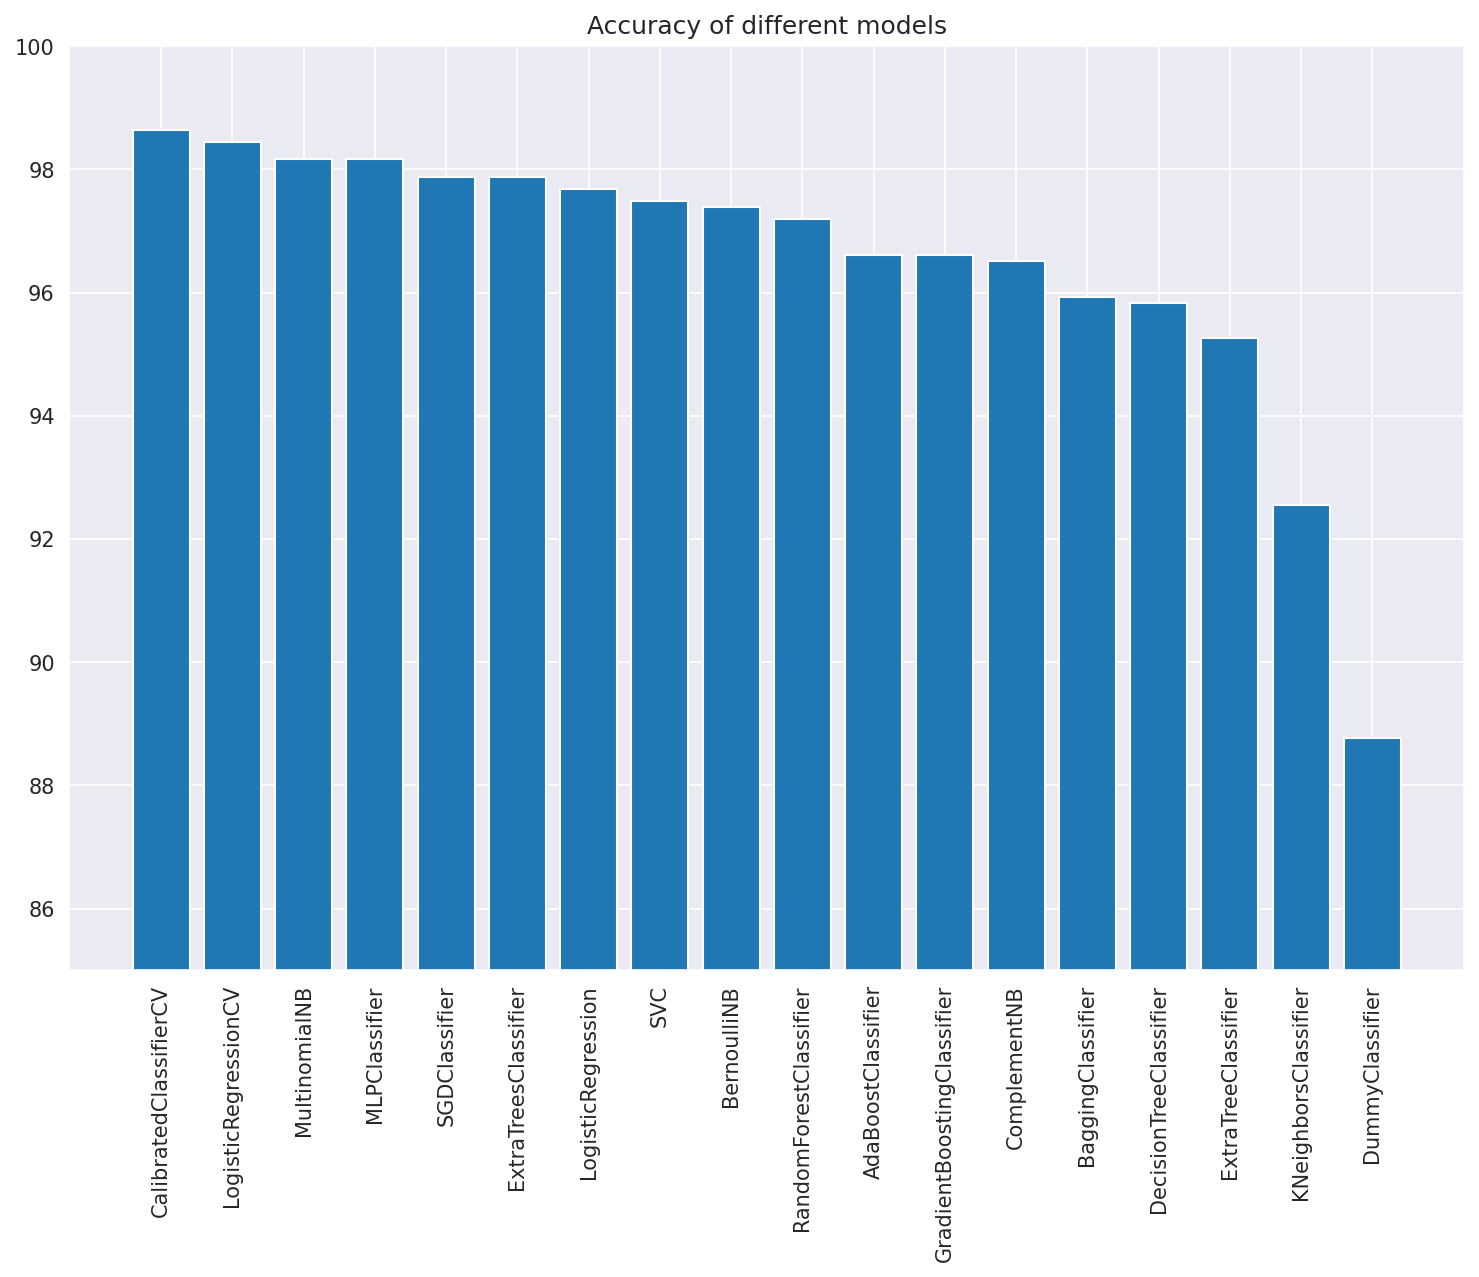

In [22]:
df_models.sort_values(by='accuracy', ascending=False, inplace=True)
plt.figure(figsize=(12, 8), dpi=150, edgecolor='black')
plt.bar(df_models['model_name'], df_models['accuracy'])
plt.xticks(rotation=90)
plt.ylim(85, 100)
plt.title('Accuracy of different models')
plt.show()

In [23]:
df_models_tfidf = pd.DataFrame(columns=['model_name', 'accuracy', 'time_taken'])

In [24]:
tfidf = TfidfVectorizer(max_features=2500)

X_train, X_test, y_train, y_test = train_test_split(df['message'], df['target'], test_size=0.2, random_state=42)    

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

trainGaus=X_train_tfidf.toarray()
testGaus=X_test_tfidf.toarray()



models = [MultinomialNB(), BernoulliNB()]
for model in models:
    model = model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    y_pred
    print(f'Accuracy of the {model} model is', accuracy_score(y_test, y_pred)*100)    

model = GaussianNB()
start = time.time()
model.fit(X_train_tfidf.toarray(), y_train)
y_pred = model.predict(X_test_tfidf.toarray())
y_pred
print(f'Accuracy of the {model} model is', accuracy_score(y_test, y_pred)*100)

Accuracy of the MultinomialNB() model is 97.87028073572121
Accuracy of the BernoulliNB() model is 98.45111326234269
Accuracy of the GaussianNB() model is 85.76960309777347


In [25]:
estimators = all_estimators()
estimators

models = []

for name, class_ in estimators:
    try:
        if hasattr(class_, 'predict_proba'):
            models.append((name, class_))
    except:
        pass


def eval(model):
    start = time.time()
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    end = time.time()
    time_taken = end - start
    accuracy = accuracy_score(y_test, y_pred)*100
    return accuracy, time_taken

for model in models:
    try:
        ans = eval(model[1]())
        df_models_tfidf = pd.concat([df_models_tfidf, pd.DataFrame([[model[0], ans[0], ans[1]]], columns=['model_name', 'accuracy', 'time_taken'])])
    except:
        pass


/home/arrry/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
df_models_tfidf

,model_name,accuracy,time_taken
0,AdaBoostClassifier,96.805421,2.863534
0,BaggingClassifier,96.127783,4.553452
0,BernoulliNB,98.451113,0.010283
0,CalibratedClassifierCV,98.063892,0.21927
0,ComplementNB,95.546951,0.006029
0,DecisionTreeClassifier,95.837367,0.722028
0,DummyClassifier,88.770571,0.001399
0,ExtraTreeClassifier,95.837367,0.031288
0,ExtraTreesClassifier,97.773475,3.661089
0,GradientBoostingClassifier,96.61181,2.551737


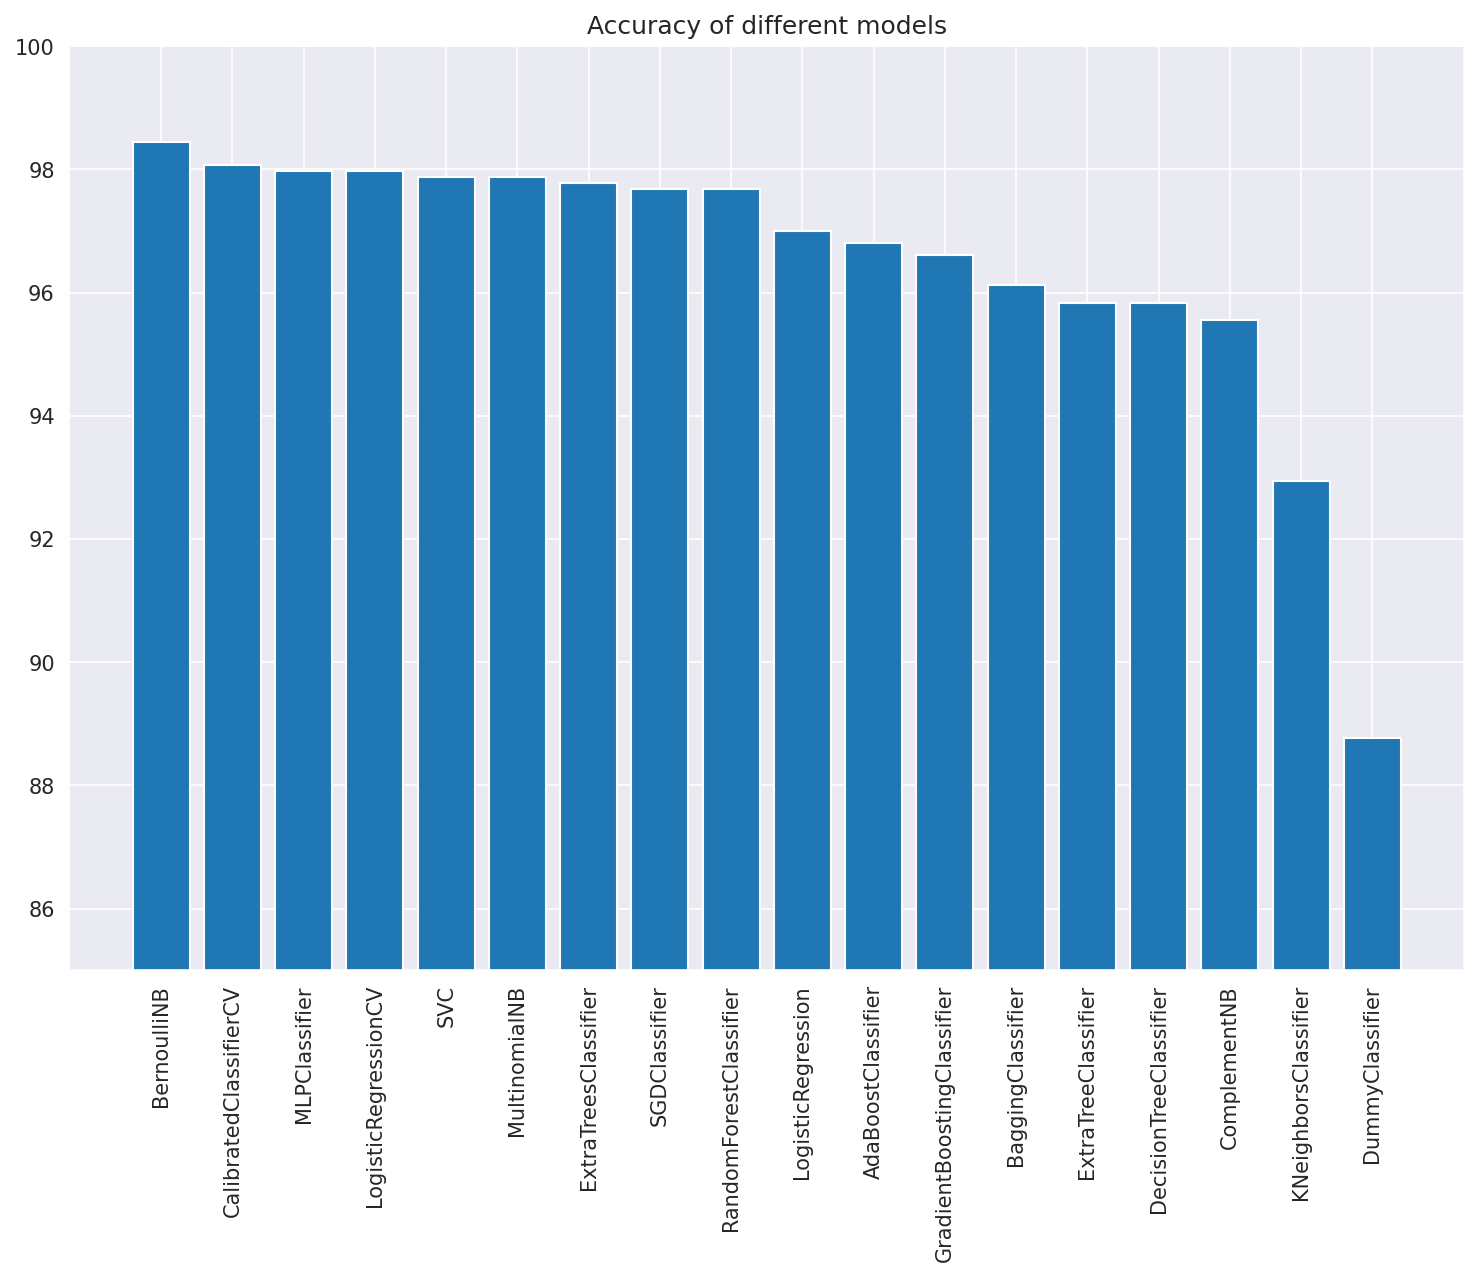

In [27]:
df_models_tfidf.sort_values(by='accuracy', ascending=False, inplace=True)
plt.figure(figsize=(12, 8), dpi=150, edgecolor='black')
plt.bar(df_models_tfidf['model_name'], df_models_tfidf['accuracy'])
plt.xticks(rotation=90)
plt.ylim(85, 100)
plt.title('Accuracy of different models')
plt.show()

In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['message'])
sequences = tokenizer.texts_to_sequences(df['message'])

MAX_LEN = 200
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN)


In [47]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=MAX_LEN))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


2023-03-30 19:38:48.759154: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-30 19:38:48.759465: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-30 19:38:48.759578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (n00b): /proc/driver/nvidia/version does not exist
2023-03-30 19:38:48.760720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           570560    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 603,649
Trainable params: 603,649
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.fit(padded_sequences, df['target'], epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
130/130 [==============================] - 180s 1s/step - loss: 0.2217 - accuracy: 0.9235 - val_loss: 0.0589 - val_accuracy: 0.9835
Epoch 2/10
130/130 [==============================] - 186s 1s/step - loss: 0.0425 - accuracy: 0.9889 - val_loss: 0.0571 - val_accuracy: 0.9845
Epoch 3/10
130/130 [==============================] - 103s 793ms/step - loss: 0.0162 - accuracy: 0.9956 - val_loss: 0.0501 - val_accuracy: 0.9845
Epoch 4/10
130/130 [==============================] - 98s 757ms/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 0.0468 - val_accuracy: 0.9894
Epoch 5/10
130/130 [==============================] - 113s 870ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0496 - val_accuracy: 0.9894
Epoch 6/10
130/130 [==============================] - 102s 786ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0576 - val_accuracy: 0.9894
Epoch 7/10
130/130 [==============================] - 123s 948ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0510 - val_ac

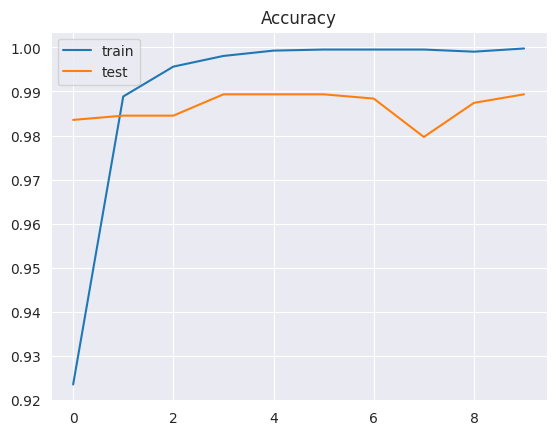

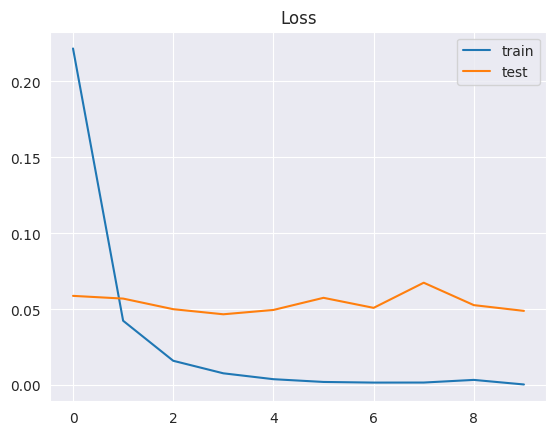

In [53]:
plt.plot(model.history.history['accuracy'], label='train')
plt.plot(model.history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='test')
plt.title('Loss')
plt.legend()
plt.show()